# Import Tools and Dataset

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
df = pd.read_csv('/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_metadata.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Access and Visualize the Dataset

In [40]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

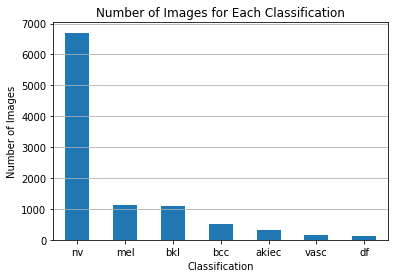

In [4]:
import matplotlib.pyplot as plt
#exp = pd.Series.to_frame(df1.groupby('dx').sex.value_counts())
df['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of Images for Each Classification')
plt.xlabel('Classification')
plt.ylabel('Number of Images')
plt.grid(axis='y')

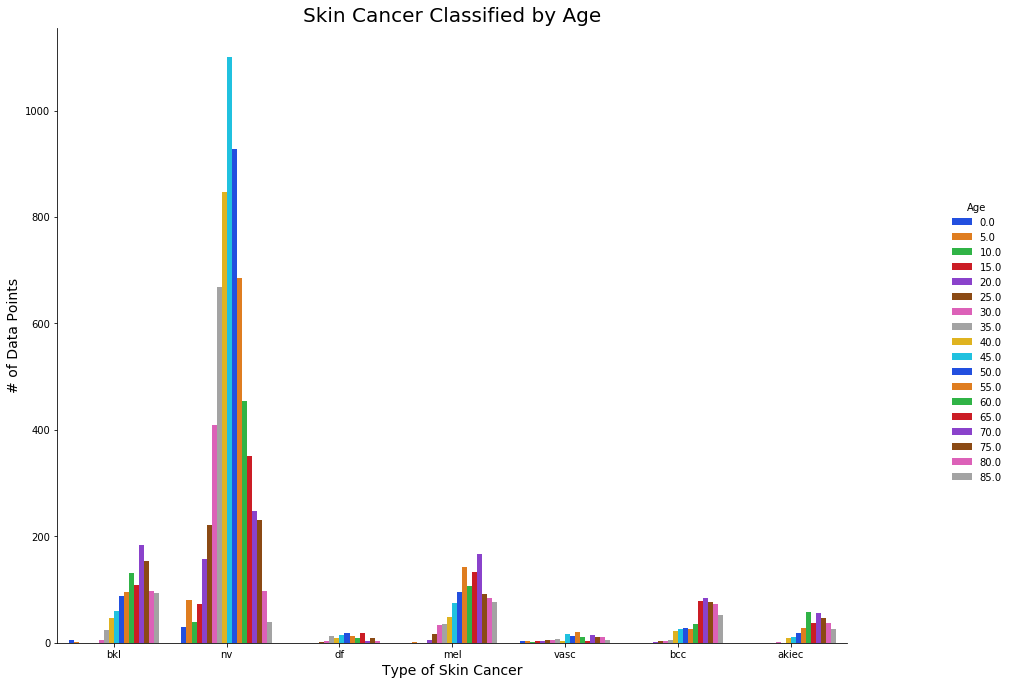

In [8]:
# Skin Cancer occurence by Age
graph = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=df)
graph.fig.set_size_inches(15,10)
graph.ax.set_title('Skin Cancer Classified by Age', fontsize=20)
graph.set_xlabels('Type of Skin Cancer', fontsize=14)
graph.set_ylabels('# of Data Points', fontsize=14)
graph._legend.set_title('Age')

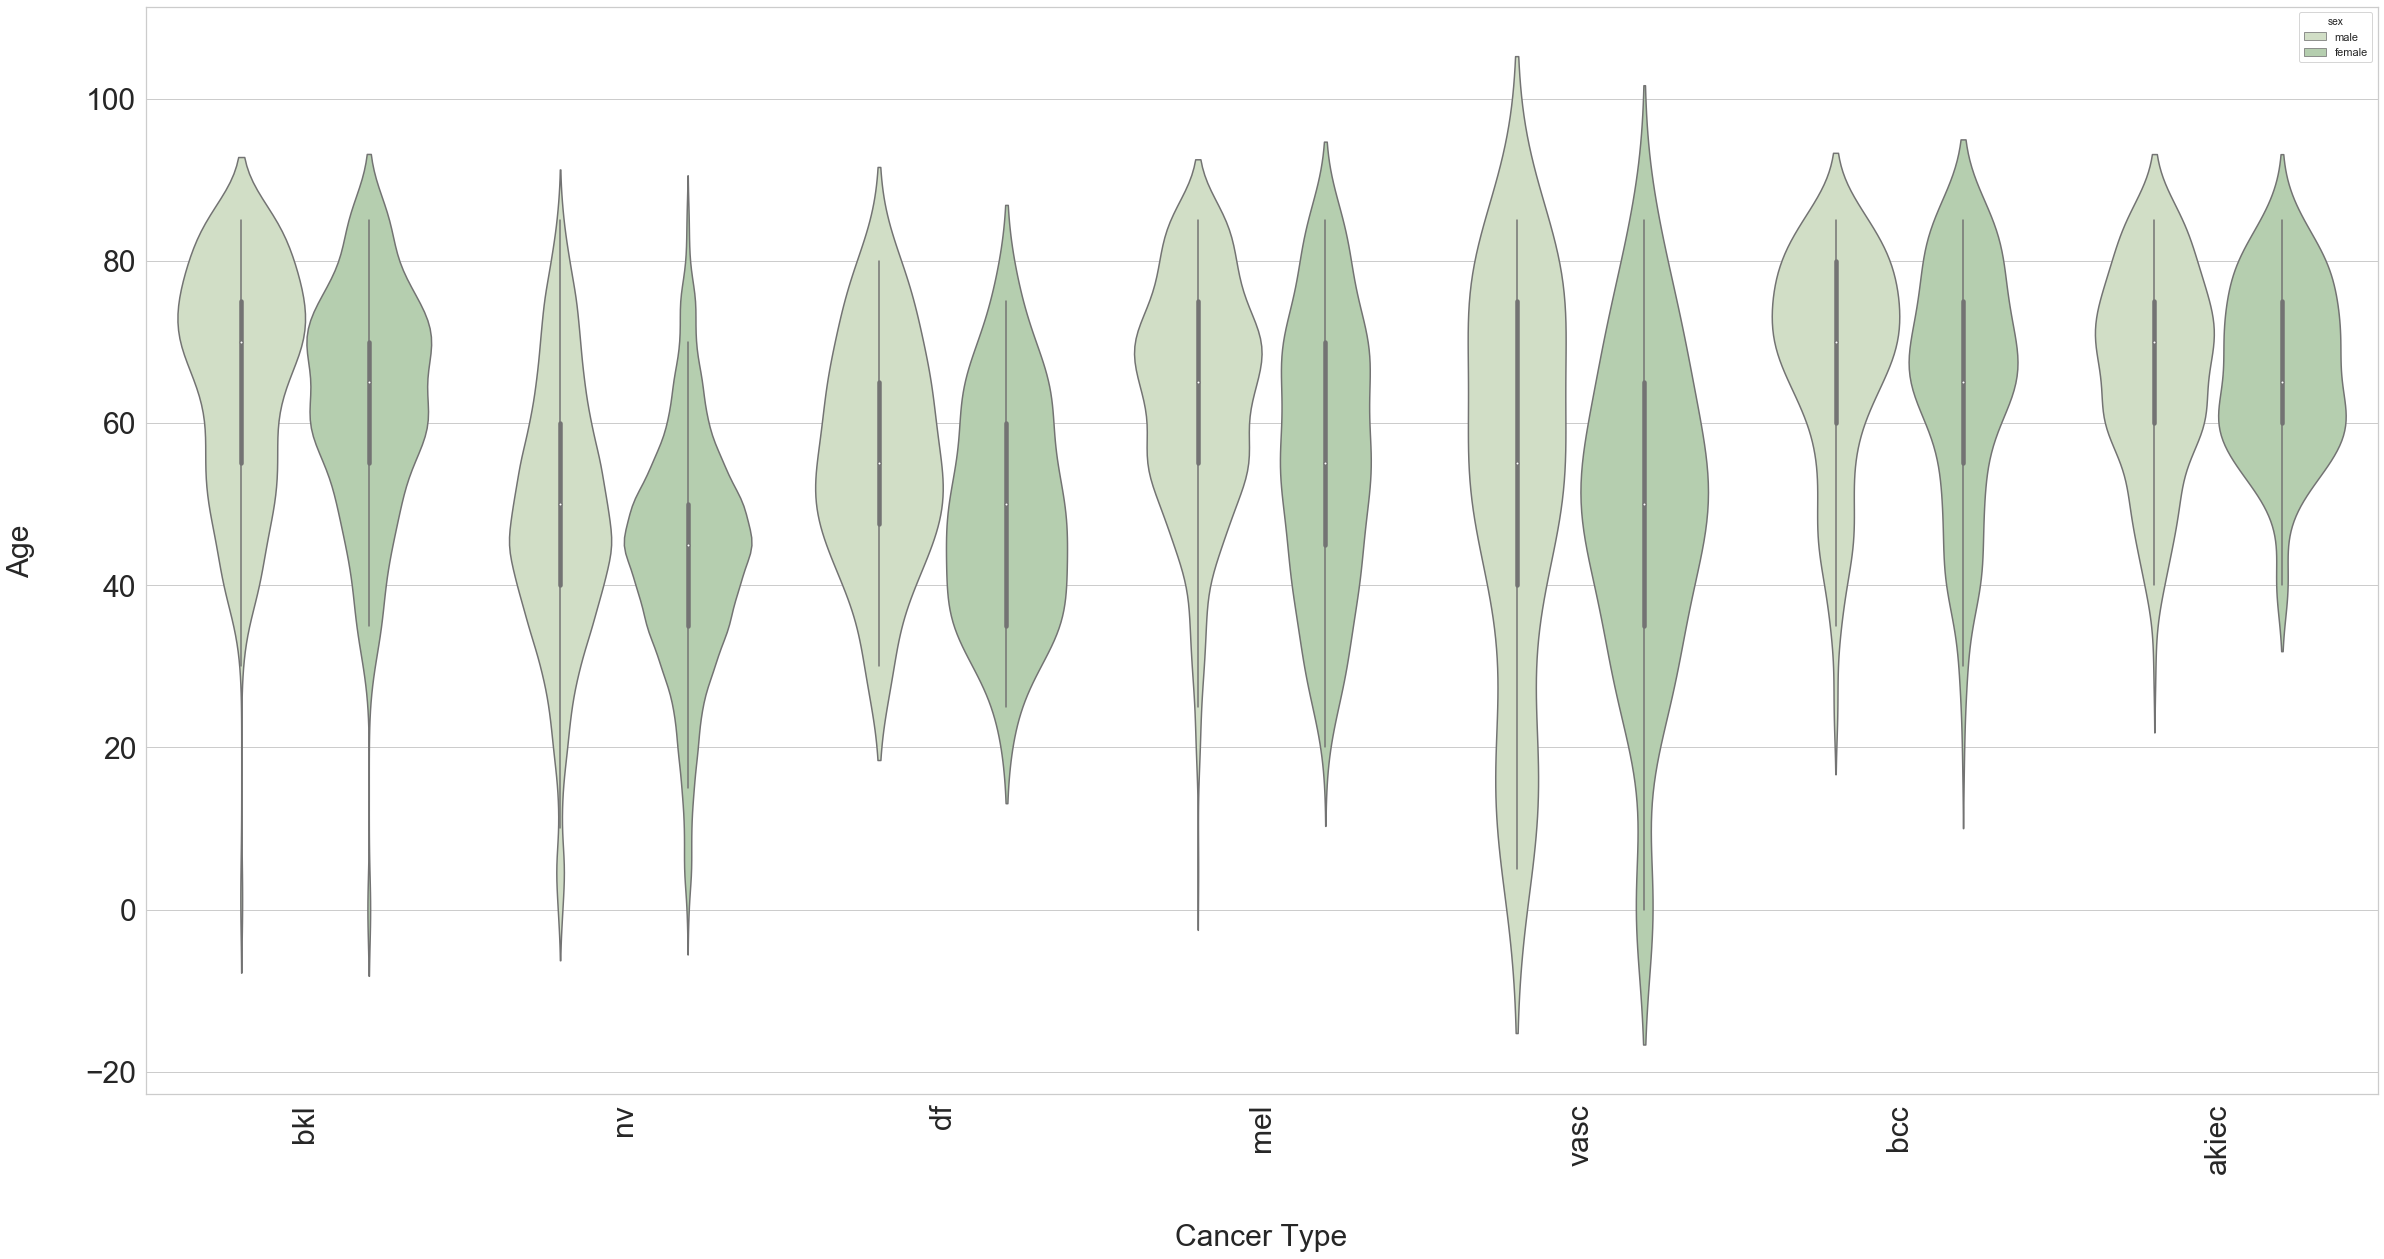

In [9]:
def age_boxplot(data):
    data = data[data['sex'] != "unknown"]
    sns.set(style="whitegrid")
    plt.figure(figsize=(40,20))
    pal = sns.cubehelix_palette(8, rot=-.5, dark=.3)
    freq = sns.violinplot(x="dx", y="age", data=data, hue="sex", palette=pal)
    plt.xticks(rotation=90)
    freq.set_xlabel("Cancer Type",fontsize=30)
    freq.set_ylabel("Age",fontsize=30)
    freq.tick_params(labelsize=30)
    freq.xaxis.labelpad = 50
    freq.yaxis.labelpad = 50
    
age_boxplot(df)

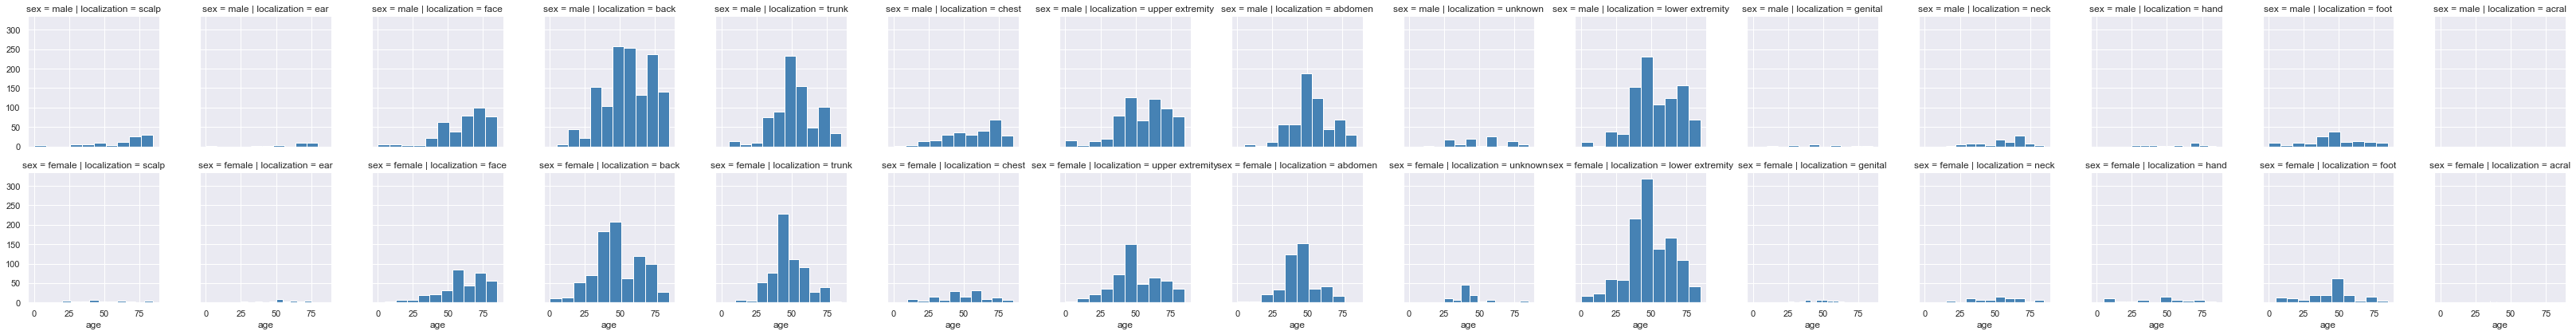

In [10]:
def localization_facetgrid(data):
    data = data[data['sex'] != "unknown"]
    sns.set(style="darkgrid")
    g = sns.FacetGrid(data, row="sex", col="localization")
    g.map(plt.hist, 'age', color="steelblue")
    
localization_facetgrid(df)

# Get Trainable Data from CSV File

In [42]:
from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_images_part_1/' + p + '.jpg'): return '/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_images_part_1/' + p + '.jpg'
    if isfile('/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_images_part_2/' + p + '.jpg'): return '/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_images_part_2/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,dx_id,image_path,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0,/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_...,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0,/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_...,"[[[24, 13, 22], [24, 13, 22], [24, 14, 25], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0,/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_...,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0,/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_...,"[[[23, 11, 16], [24, 11, 19], [26, 13, 22], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0,/Users/Nathan Pogue/Desktop/HAM10000/HAM10000_...,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."


In [43]:
from sklearn.model_selection import train_test_split

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 700)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 234)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)

def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])
print(np.shape(trainimages))
print(np.shape(testimages))
print(np.shape(validationimages))

(8029, 112, 150, 3)
(1103, 112, 150, 3)
(883, 112, 150, 3)


# Data Augmentation

In [44]:
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True, 
        vertical_flip=True)

In [45]:
data_gen.fit(trainimages)

# Build CNN Model

In [46]:
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (112, 150, 3)

num_labels = 7

base_model = InceptionV3(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = '/Users/Nathan Pogue/Desktop/HAM10000/inception_v3_weights.h5')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

#for layer in base_model.layers[-30:]:
 #   layer.trainable = True

#model.add(ResNet50(include_top = False, pooling = 'max', weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


# Train Model

In [47]:
from tensorflow.python.keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [48]:
import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoint = CustomModelCheckPoint()
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '/Users/Nathan Pogue/Desktop/HAM10000/best2.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
epochs = 12 
batch_size = 20
trainhistory = model.fit_generator(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validationimages,validationlabels),
                              verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                                       callbacks=[cb_checkpointer, cb_early_stopper])


Epoch 1/12
402/402 [==============================] - 1674s 4s/step - loss: 2.8648 - acc: 0.6592 - val_loss: 1.1506 - val_acc: 0.8313
Epoch 2/12
402/402 [==============================] - 1661s 4s/step - loss: 1.1652 - acc: 0.6986 - val_loss: 0.7633 - val_acc: 0.8097
Epoch 3/12
402/402 [==============================] - 1665s 4s/step - loss: 0.9644 - acc: 0.7091 - val_loss: 0.7290 - val_acc: 0.8018
Epoch 4/12
402/402 [==============================] - 1611s 4s/step - loss: 0.9172 - acc: 0.7120 - val_loss: 0.9999 - val_acc: 0.8494
Epoch 5/12
402/402 [==============================] - 1622s 4s/step - loss: 0.9012 - acc: 0.7142 - val_loss: 0.5723 - val_acc: 0.8494
Epoch 6/12
402/402 [==============================] - 1611s 4s/step - loss: 0.8746 - acc: 0.7294 - val_loss: 0.5700 - val_acc: 0.8460
Epoch 7/12
402/402 [==============================] - 1611s 4s/step - loss: 0.8497 - acc: 0.7307 - val_loss: 0.6258 - val_acc: 0.8324
Epoch 8/12
402/402 [==============================] - 1606s 4s

# Save Model

In [49]:
model.save('/Users/Nathan Pogue/Desktop/HAM10000/model2InceptionV3.hdf5')

# Visualize Accuracy

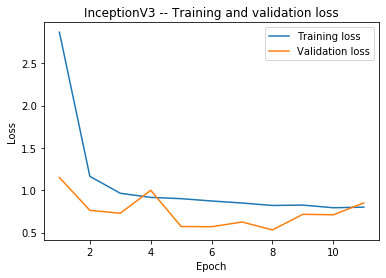

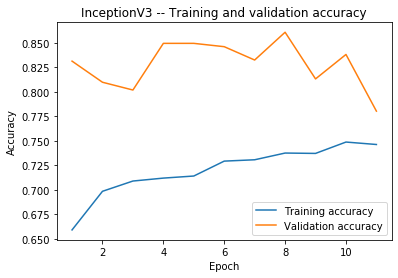

In [50]:
import matplotlib.pyplot as plt
acc = trainhistory.history['acc']
val_acc = trainhistory.history['val_acc']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('InceptionV3 -- Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('InceptionV3 -- Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Test Model on Test Data

In [51]:
model.load_weights('/Users/Nathan Pogue/Desktop/HAM10000/model2InceptionV3.hdf5')
test_loss, test_acc = model.evaluate(testimages, testlabels, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 26s 23ms/sample - loss: 0.8582 - acc: 0.8042
test_accuracy = 0.804170  ;  test_loss = 0.858239


# Classification Report

In [52]:
from sklearn.metrics import classification_report

train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

labels = labeldict.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.32      0.86      0.46        87
          nv       0.96      0.90      0.93       886
          df       0.00      0.00      0.00         8
         mel       0.29      0.22      0.25        36
        vasc       0.00      0.00      0.00        14
         bcc       0.62      0.12      0.21        40
       akiec       0.50      0.06      0.11        32

    accuracy                           0.80      1103
   macro avg       0.38      0.31      0.28      1103
weighted avg       0.85      0.80      0.80      1103



C:\Users\Nathan Pogue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
